# Wrangling Data From Bay Area Bike Share Published Data - Trips

### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from wranglingutils import time_marker as tm
from wranglingutils import csv_chunk_importer

In [3]:
from math import ceil

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25
TICK_FONT_SIZE = LABEL_FONT_SIZE*0.8
FIG_SIZE = (15,6)

## Import Data

In [5]:
tip_df_columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 
                  'end_date', 'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 
                  'zip_code']

trips_df = csv_chunk_importer(file_path_slug='../../source_data/bayareabikeshare/*trip_data.csv', 
                                 column_labels=tip_df_columns, 
                                 chunk_size=10000, 
                                 drop_dups=True)

[23:04:04.628457] Started Loading Data...
[23:04:06.086642] Finished file! (1 of 4)
[23:04:06.614698] Finished file! (2 of 4)
[23:04:08.312682] Finished file! (3 of 4)
[23:04:09.138578] Finished file! (4 of 4)
[23:04:09.138866] concatenating chunks...
[23:04:11.964061] Data Loaded Successfully!


In [6]:
sf_stations_df = csv_chunk_importer(file_path_slug='../../clean_data/bayareabikeshare/sf_station_*.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)
sf_station_ids = sf_stations_df.station_id.unique()

[23:04:12.022873] Started Loading Data...
[23:04:12.035477] Finished file! (1 of 1)
[23:04:12.035590] concatenating chunks...
[23:04:12.046207] Data Loaded Successfully!


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [7]:
def clean_zipcode(item):
    ''' Zipcodes in this data set are self reported rider zipcodes
        and the method of entry for these zipcodes is reported to 
        not be very clear for users, we are using a heavy hand 
        when cleaning up zip codes'''

    zip_string = str(item)
    
    # if zipcode is not 5 characters long
    if len(zip_string) > 5:
        # try splitting on a few different characters

        # split on '-'
        try:
            result = zip_string.split('-')[0]
        except:
            result = zip_string
        
        # split on '.'
        try:
            result = zip_string.split('.')[0]
        except:
            result = zip_string
            
        # take only first 5 characters
        result = result[:5]

        # if len of zipstring is less than 5, return 'NaN'
        if len(result) < 5:
            return 99999

    # if it is 5 characters long, move along
    else:
        result = zip_string
    
    # make sure result is all digits
    if result.isdigit():
        result = int(result)
        return result
    else:
        return 99999


def clean_trip_frame(df):
    '''Basic Cleanup of column types and appends a 'duration_minutes' 
        column converted from given 'duration' which is in seconds'''
    # set column types
    tm('Setting data types...')
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    tm('add duration_minutes column')
    df['duration_minutes'] = df.duration.apply(lambda x: x/60.)
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # add 'billed_minutes' and 'billed_periods' columns
    # customers are billed by the minute, round up to nearest minute duration
    # a billed period is 5 minutes long
    df['billed_minutes'] = df.duration.apply(lambda x: ceil(x/60.))
    df['billed_minutes'] = df['billed_minutes'].astype('int')
    df['billed_periods'] = df.billed_minutes.apply(lambda x: int(ceil(x/5)))
    
    # Clean Zipcode
    tm('cleaning zipcodes')
    df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    df.reset_index(inplace=True, drop=True)
    
    tm('done!')
    return df

# Cleaning Data
<ul>
    <li>Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes</li>
    <li>For other data it is mostly just setting a propper data type</li>
    <li>
        <ul>Duration is convered to billable time windows as:
            <li>`billed_minutes` rounds up rental duration minutes to next full minute</li>
            <li>`billed_periods` is the number of 5 minute intervals in `billed_minutes`, rounded up to the next full period</li>
        <ul>
    </li>
</ul>

In [8]:
# clean data frames
tm('Trip Data Cleanup Started')
trips_df = clean_trip_frame(trips_df)
tm('Cleanup Complete!')

[23:04:12.399555] Trip Data Cleanup Started
[23:04:12.400511] Setting data types...
[23:04:22.234862] add duration_minutes column
[23:04:24.113032] cleaning zipcodes
[23:04:25.566241] done!
[23:04:25.566480] Cleanup Complete!


In [9]:
trips_df.head(3).transpose()

,0,1,2
trip_id,913465,913466,913467
duration,746,969,233
start_date,2015-09-01 00:10:00,2015-09-01 00:15:00,2015-09-01 00:15:00
start_station_name,San Francisco Caltrain 2 (330 Townsend),Clay at Battery,Davis at Jackson
start_terminal,69,41,42
end_date,2015-09-01 00:23:00,2015-09-01 00:31:00,2015-09-01 00:19:00
end_station_name,San Francisco City Hall,Washington at Kearny,Commercial at Montgomery
end_terminal,58,46,45
bike_id,238,16,534
user_type,Subscriber,Subscriber,Subscriber


In [10]:
trips_df.describe()

,trip_id,duration,start_terminal,end_terminal,bike_id,user_zip,duration_minutes,billed_minutes,billed_periods
count,9.836480e+05,9.836480e+05,983648.000000,983648.000000,983648.000000,983648.000000,983648.000000,983648.000000,983648.000000
mean,6.721238e+05,1.018932e+03,58.121022,58.100089,423.319779,91195.494468,16.982206,17.473353,3.884966
std,3.851056e+05,1.841684e+04,16.841133,16.912386,158.071344,15400.326413,306.947284,306.946965,61.390235
min,4.069000e+03,6.000000e+01,2.000000,2.000000,9.000000,0.000000,1.000000,1.000000,1.000000
25%,3.359168e+05,3.470000e+02,50.000000,50.000000,328.000000,94103.000000,5.783333,6.000000,2.000000
50%,6.779755e+05,5.180000e+02,62.000000,62.000000,437.000000,94111.000000,8.633333,9.000000,2.000000
75%,1.001672e+06,7.480000e+02,70.000000,70.000000,544.000000,94598.000000,12.466667,13.000000,3.000000
max,1.338408e+06,1.727040e+07,91.000000,91.000000,878.000000,99999.000000,287840.000000,287840.000000,57568.000000


# Correct Relocated Stations

<p> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated </p>

In [11]:
def date_fixes(df, old_terminal, new_terminal, change_date):
    '''Correct dates on terminal relocations'''
        
    # Fix A to B - Start Terminal
    tm('Setting {} to {} occuring before {}'.format(old_terminal, new_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal

    # Fix A to B - End Terminal
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    
    # Fix B to A - Start Terminal
    tm('Setting {} to {} occuring after  {}'.format(new_terminal, old_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal

    # Fix B to A - End Terminal
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    
    return df

#### On July 5, 2016 station 23 was relocated to station 88, and station 24 was relocated to station 89

In [12]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 23, 88, change_date)
trips_df = date_fixes(trips_df, 24, 89, change_date)

[23:04:26.659404] Setting 23 to 88 occuring before 2016-07-05 00:00:00
	Updating 0 records...
	Updating 0 records...
[23:04:26.818620] Setting 88 to 23 occuring after  2016-07-05 00:00:00
	Updating 9 records...
	Updating 18 records...
[23:04:26.892619] Setting 24 to 89 occuring before 2016-07-05 00:00:00
	Updating 0 records...
	Updating 0 records...
[23:04:26.968529] Setting 89 to 24 occuring after  2016-07-05 00:00:00
	Updating 11 records...
	Updating 9 records...


#### On August 4, 2016 station 25 was relocated to station 91, and station 26 was relocated to station 90

In [13]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 25, 91, change_date)
trips_df = date_fixes(trips_df, 26, 90, change_date)

[23:04:27.056854] Setting 25 to 91 occuring before 2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[23:04:27.137713] Setting 91 to 25 occuring after  2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[23:04:27.205947] Setting 26 to 90 occuring before 2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...
[23:04:27.280313] Setting 90 to 26 occuring after  2016-08-04 00:00:00
	Updating 0 records...
	Updating 0 records...


## Prune Trips not within San Francisco
<p>We are only concerned with trips that both start and end at San Francisco Stations in this analysis, remove all others</p>

In [14]:
tm('Subset to only include trips that are within San Francisco')
trips_df = trips_df[(trips_df.start_terminal.isin(sf_station_ids)) & (trips_df.end_terminal.isin(sf_station_ids))].copy()
tm('done')

[23:04:27.361989] Subset to only include trips that are within San Francisco
[23:04:27.557516] done


## Prune Trips to only those less than 3 hours long
<p>The duration in minutes of each trip has a very large spread, with the longest trip (an extreme outlier) taking nearly 200 days to complete a trip!  The Bay Area Bike Share bills in Customer and Subscriber Tiers that allow for different pricing, but the global truth is that no rider can use a bike as part of the program for more than 3 hour without incurring a heafty set of fees.</p>
<p>In fact, the idealized window set out by the program is for just 30 minutes, with a minute by minute charge being tacked onto rentals for each minute the bike is not returned after that.</p>

<ul>
    <li>There are 983648 total recorded trips</li>
    <li>There are 936280 trips 30 minutes or less, this is 95.184 of all recorded trips</li>
    <li>There are 973074 trips 3 hours or less, this is 98.925 of all recorded trips</li>
</ul>

In [15]:
count_30min_trips = trips_df[trips_df.duration_minutes < 30].shape[0]
count_3hr_trips = trips_df[trips_df.duration_minutes < 180].shape[0]

print('There are {:d} total recorded trips'.format(trips_df.shape[0]))
print('There are {:d} trips 30 minutes or less, this is {:2.3f} of all recorded trips'.format(count_30min_trips, 100.*count_30min_trips/trips_df.shape[0]))
print('There are {:d} trips 3 hours or less, this is {:2.3f} of all recorded trips'.format(count_3hr_trips, 100.*count_3hr_trips/trips_df.shape[0]))

There are 891200 total recorded trips
There are 851921 trips 30 minutes or less, this is 95.593 of all recorded trips
There are 882240 trips 3 hours or less, this is 98.995 of all recorded trips


In [16]:
def plot_billed_min_distribution(df, max_minutes=180, file_suffix='3hr'):
    df_subset = df[df.billed_minutes <= max_minutes].copy()

    plt.subplots(figsize=FIG_SIZE)
    ax = sns.countplot(x="billed_minutes", data=df_subset, palette='Blues_r')

    plt.xlabel('Trip Duration (Billed Minutes)', size=LABEL_FONT_SIZE)
    plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE)
    plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE)

    x_ticks = [x for x in range(0, max_minutes+5, 5)]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], size=TICK_FONT_SIZE)
    for x in x_ticks:
        ax.axvline(x, color='k', alpha=0.15, linestyle=':')


    y_ticks = [y for y in range(0, 100000, 10000)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(['{:d}K'.format(int(y/1000)) for y in y_ticks], size=TICK_FONT_SIZE)

    plt.grid(False)
    plt.tight_layout()
    plt.savefig('../../charts/trip_duration_distribution_{}.png'.format(file_suffix))
    plt.show()
    plt.close()

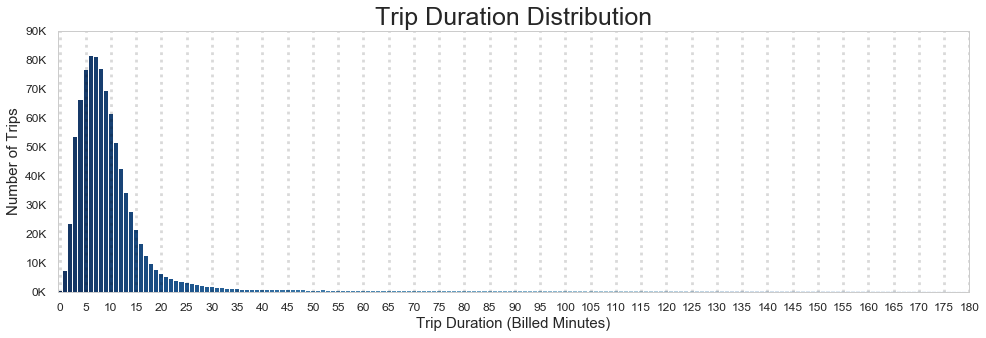

In [17]:
plot_billed_min_distribution(trips_df, max_minutes=180, file_suffix='3hr')

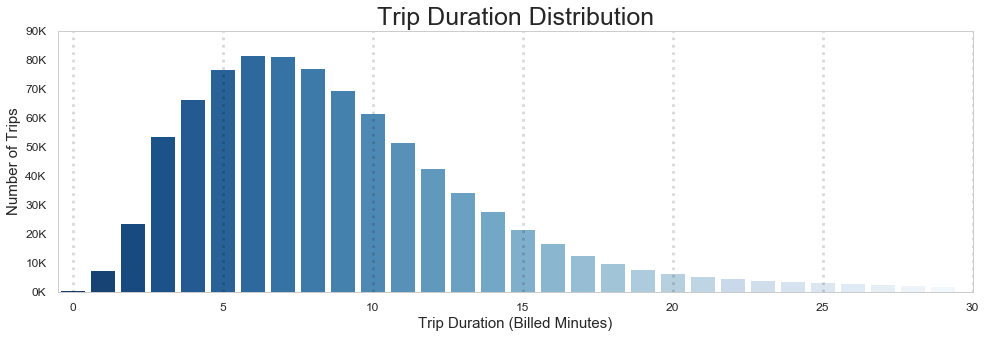

In [18]:
plot_billed_min_distribution(trips_df, max_minutes=30, file_suffix='30min')

In [19]:
# prune data to exclude trips longer than 3 hours
tm('Removing trips longer than 3 hours')

cutoff_minutes = 180

trips_df = trips_df[trips_df.billed_minutes < cutoff_minutes].copy()
trips_df.reset_index(inplace=True, drop=True)

print(trips_df.shape)
tm('done!')

[23:04:30.587611] Removing trips longer than 3 hours
(882190, 14)
[23:04:30.838675] done!


In [20]:
trips_df.head(3).transpose()

,0,1,2
trip_id,913465,913466,913467
duration,746,969,233
start_date,2015-09-01 00:10:00,2015-09-01 00:15:00,2015-09-01 00:15:00
start_station_name,San Francisco Caltrain 2 (330 Townsend),Clay at Battery,Davis at Jackson
start_terminal,69,41,42
end_date,2015-09-01 00:23:00,2015-09-01 00:31:00,2015-09-01 00:19:00
end_station_name,San Francisco City Hall,Washington at Kearny,Commercial at Montgomery
end_terminal,58,46,45
bike_id,238,16,534
user_type,Subscriber,Subscriber,Subscriber


## Clean Up Column Labels

In [21]:
trips_df.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 
                    'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 
                    'bike_id', 'user_type', 'user_zip', 'duration_minutes', 
                    'billed_minutes', 'billed_periods']
trips_df.head()

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,user_type,user_zip,duration_minutes,billed_minutes,billed_periods
0,913465,746,2015-09-01 00:10:00,San Francisco Caltrain 2 (330 Townsend),69,2015-09-01 00:23:00,San Francisco City Hall,58,238,Subscriber,94107,12.433333,13,3
1,913466,969,2015-09-01 00:15:00,Clay at Battery,41,2015-09-01 00:31:00,Washington at Kearny,46,16,Subscriber,94133,16.150000,17,4
2,913467,233,2015-09-01 00:15:00,Davis at Jackson,42,2015-09-01 00:19:00,Commercial at Montgomery,45,534,Subscriber,94111,3.883333,4,1
3,913468,213,2015-09-01 01:29:00,Clay at Battery,41,2015-09-01 01:32:00,Steuart at Market,74,312,Subscriber,94107,3.550000,4,1
4,913469,574,2015-09-01 01:33:00,Steuart at Market,74,2015-09-01 01:42:00,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107,9.566667,10,2


# Write Data to File

In [22]:
trips_df.to_csv('../../clean_data/bayareabikeshare/sf_trips_data_3hr_cleaned.csv', encoding='utf-8')

In [23]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882190 entries, 0 to 882189
Data columns (total 14 columns):
trip_id               882190 non-null int64
duration              882190 non-null int64
start_date            882190 non-null datetime64[ns]
start_station_name    882190 non-null object
start_station_id      882190 non-null int64
end_date              882190 non-null datetime64[ns]
end_station_name      882190 non-null object
end_station_id        882190 non-null int64
bike_id               882190 non-null int64
user_type             882190 non-null category
user_zip              882190 non-null int64
duration_minutes      882190 non-null float64
billed_minutes        882190 non-null int64
billed_periods        882190 non-null int64
dtypes: category(1), datetime64[ns](2), float64(1), int64(8), object(2)
memory usage: 88.3+ MB
